Author: Jean-François Berger-Lefébure
Link: https://github.com/jfbl369

# DAX40 Prediction algorithme
### Long Short Term Memory (LSTM)

The LSTM cell is the basic building block of the LSTM network. It consists of three gates (input, forget, and output) that control the flow of information into and out of the cell, and a memory cell that stores the information. The gates use activation functions to decide which information to let in or out, and how much to keep or discard. The LSTM cell allows the network to selectively learn and remember important features of the input sequence, while ignoring irrelevant or redundant information.

In [26]:
from IPython.display import HTML, display
display(HTML("<figure><img src='https://www.baeldung.com/wp-content/uploads/sites/4/2022/01/bilstm-1-1024x384.png'><figcaption><strong>Credit:</strong> https://www.baeldung.com/cs/bidirectional-vs-unidirectional-lstm</figcaption></figure>"))

## 1. Downloading resources

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from tensorflow.keras.models import Sequential
from keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from numpy import array
import time

In [3]:
#Timer
start_time = time.time()

In [4]:
#Download DAX40 historical
df_LSTM = yf.download("^GDAXI", start="2000-01-01", end="2022-12-31")
df_LSTM = df_LSTM[["Close"]]

[*********************100%***********************]  1 of 1 completed


## 2.Data normalization

In [5]:
#Normalizing
Close_original = df_LSTM.copy()
scaler=MinMaxScaler(feature_range=(0,1))
df_LSTM=scaler.fit_transform(np.array(df_LSTM).reshape(-1,1))
print(df_LSTM.shape)

(5839, 1)


## 3.Data split: train/test

In [6]:
#Split train_test 70/30
training_size=int(len(df_LSTM)*0.70)
test_size=len(df_LSTM)-training_size
train_data,test_data=df_LSTM[0:training_size,:],df_LSTM[training_size:len(df_LSTM),:1]
print("\033[1mTrain_test_split shape:\033[0m")
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

Train_test_split shape:
train_data:  (4087, 1)
test_data:  (1752, 1)


## 4. Reshape dataset for LSTM model

In [7]:
#Reshape dataset
time_step = 100
X_train = []
y_train = []
for i in range(time_step, len(train_data)):
    X_train.append(train_data[i-time_step:i])
    y_train.append(train_data[i])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i])
    y_test.append(test_data[i])
X_test, y_test = np.array(X_test), np.array(y_test)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (3987, 100, 1)
X_test:  (1652, 100, 1)


## 5. Fit model: LSTM (Bidirectional)

In [8]:
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=100, verbose=2)

Epoch 1/100
40/40 - 29s - loss: 0.0066 - val_loss: 0.0017 - 29s/epoch - 727ms/step
Epoch 2/100
40/40 - 29s - loss: 6.3172e-04 - val_loss: 0.0011 - 29s/epoch - 720ms/step
Epoch 3/100
40/40 - 30s - loss: 3.6830e-04 - val_loss: 7.7838e-04 - 30s/epoch - 738ms/step
Epoch 4/100
40/40 - 30s - loss: 2.3257e-04 - val_loss: 5.3023e-04 - 30s/epoch - 756ms/step
Epoch 5/100
40/40 - 30s - loss: 1.7237e-04 - val_loss: 7.1347e-04 - 30s/epoch - 758ms/step
Epoch 6/100
40/40 - 31s - loss: 1.5973e-04 - val_loss: 6.2217e-04 - 31s/epoch - 781ms/step
Epoch 7/100
40/40 - 32s - loss: 1.5029e-04 - val_loss: 5.1978e-04 - 32s/epoch - 792ms/step
Epoch 8/100
40/40 - 31s - loss: 1.4181e-04 - val_loss: 6.7025e-04 - 31s/epoch - 774ms/step
Epoch 9/100
40/40 - 31s - loss: 1.3692e-04 - val_loss: 4.9547e-04 - 31s/epoch - 766ms/step
Epoch 10/100
40/40 - 30s - loss: 1.3124e-04 - val_loss: 3.6608e-04 - 30s/epoch - 755ms/step
Epoch 11/100
40/40 - 31s - loss: 1.2650e-04 - val_loss: 5.2079e-04 - 31s/epoch - 765ms/step
Epoch 12/

In [9]:
#Display
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100, 200)         81600     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 322,601
Trainable params: 322,601
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Prediction
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

print("\033[1mShape prediction:\033[0m")
print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

52/52 [==============================] - 1s 22ms/step
Shape prediction:
Train data prediction: (3987, 1)
Test data prediction: (1652, 1)


## 6.Scoring

In [11]:
#Transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data MAE:  72.36344658225173
-------------------------------------------------------------------------------------
Test data MAE:  120.93832995989706


## 7.Grap-Visualization

In [12]:
#Set-up train prediction for plotting
look_back=time_step
trainPredictPlot = np.empty_like(df_LSTM)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

#Set-up test prediction for plotting
test_préd_close = np.empty_like(df_LSTM)
test_préd_close[:, :] = np.nan
test_préd_close[len(train_predict)+(look_back*2):len(train_predict)+(look_back*2)+len(test_predict), :] = test_predict
print("Test predicted data: ", test_préd_close.shape)

Train predicted data:  (5839, 1)
Test predicted data:  (5839, 1)


In [13]:
#Dataset creation for plotting
Close_original["Close"]
train_préd_close = trainPredictPlot.reshape(1,-1)[0].tolist()
test_préd_close = test_préd_close.reshape(1,-1)[0].tolist()
Plot_DF_LSTM = pd.DataFrame({"Close": Close_original["Close"], "train_prédiction_close":train_préd_close, "test_prédiction_close": test_préd_close})

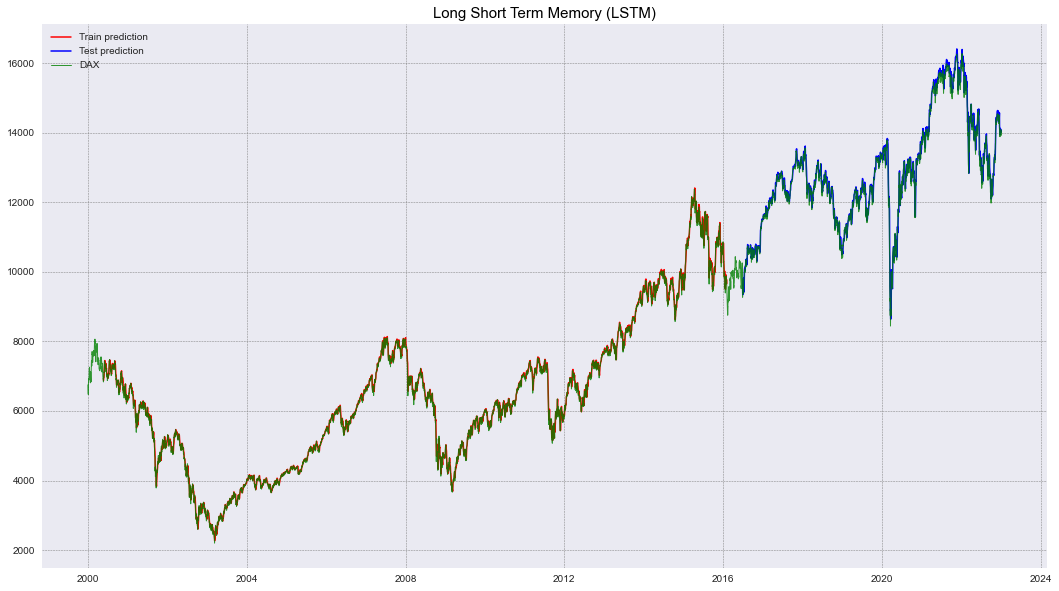

In [15]:
#Grap-Visualization
plt.figure(figsize=(18,10))
plt.style.use("seaborn")
plt.plot(Close_original.index, Plot_DF_LSTM["train_prédiction_close"], linewidth=1.5, color="red", alpha=1, label="Train prediction")
plt.plot(Close_original.index, Plot_DF_LSTM["test_prédiction_close"], linewidth=1.5, color="blue", alpha=1, label="Test prediction")
plt.plot(Plot_DF_LSTM.index, Close_original["Close"], linewidth=1, color="green", alpha=0.8, label="DAX")
plt.title("Long Short Term Memory (LSTM)", fontsize=15, color='black')
plt.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray")
_=plt.legend(loc="upper left")

In [16]:
## 8. Prediction of the next 10 days

In [17]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output = []
pred_days = 10

for i in range(pred_days):
    
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:]).reshape(1, -1, 1)  
        yhat = model.predict(x_input)
        temp_input.extend(yhat[0].tolist()) 
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=2)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())

1/1 - 0s - 14ms/epoch - 14ms/step
1/1 [==============================] - 0s 14ms/step


In [18]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)

In [19]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(df_LSTM[len(df_LSTM)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
Plot_DF_LSTM2 = pd.DataFrame({"last_original_days_value":last_original_days_value,"next_predicted_days_value":next_predicted_days_value})

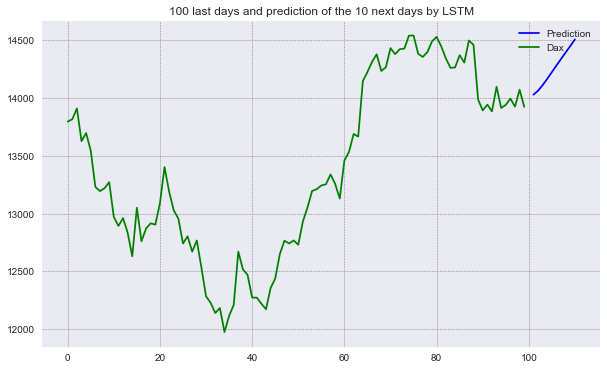

In [20]:
#Grap-Visualization
fig = plt.figure(figsize=(10, 6))
plt.plot(Plot_DF_LSTM2.index[100:], Plot_DF_LSTM2["last_original_days_value"][100:], color="blue", label="Prediction")
plt.plot(Plot_DF_LSTM2.index[:100], Plot_DF_LSTM2["next_predicted_days_value"][:100], color="green", label="Dax")
plt.title("100 last days and prediction of the 10 next days by LSTM")
plt.legend(loc="upper right")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray")

In [21]:
#End of stopwatch
end_time = time.time()
elapsed_time = round(end_time - start_time, 2)
print("Elapsed time: ", elapsed_time, "secondes")

Elapsed time:  2838.25 secondes
